In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
!pip install lime==0.2.0.1
!pip install shap==0.35.0
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding, Flatten, Input, LSTM
from keras.optimizers import Nadam, RMSprop
from keras.layers.normalization import BatchNormalization

from tensorflow.keras.backend import print_tensor
from tensorflow.keras.utils import plot_model
from tensorflow.compat.v1 import disable_v2_behavior#, ConfigProto, Session
from tensorflow.compat.v1.keras.backend import get_session
disable_v2_behavior()

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

lime_pal = sns.diverging_palette(100, 200, s=150, as_cmap=True)
shap_pal = sns.diverging_palette(0, 240, s=150, as_cmap=True)

sns.set_style('whitegrid')

In [5]:
dataset_ref = "production"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = True
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 0.25
exp_iter = 1
max_feat = 10

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"],# "sepsis_cases_2", "sepsis_cases_4"]
    "production" : ["production"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['production']

In [6]:
  for dataset_name in datasets:
      
      dataset_manager = DatasetManager(dataset_name)
      
      for ii in range(n_iter):
          if cls_method == "lstm":
              num_buckets = 1
          else:
              num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])

          all_pref_len = []
          all_feat_len = []
          all_shap_times = []
          all_lime_times = []
          sep_pref_len = []
          sep_feat_len = []
          all_times = []
          all_types = []

          sep_data_dict = {'Prefix Length': sep_pref_len, 'Feature Vector Length': sep_feat_len, 'SHAP Running Time': all_shap_times, 'LIME Running Time': all_lime_times}
          all_data_dict = {'Prefix Length': all_pref_len, 'Feature Vector Length': all_feat_len, 'Explainer': all_types, 'Running Time': all_times}
          sep_timing_path = os.path.join(PATH, "%s/%s_%s/sep_timing.csv" % (dataset_ref, cls_method, method_name))
          all_timing_path = os.path.join(PATH, "%s/%s_%s/all_timing.csv" % (dataset_ref, cls_method, method_name))


          for bucket in range(num_buckets):
              if cls_method == "lstm":
                bucketID = "all"
              else:
                bucketID = bucket+1
              print ('Bucket', bucketID)

              if cls_method == "lstm":
                  print("get everything to create model")
                  params_path = os.path.join(PATH, "%s/%s_%s/cls/params.pickle" % (dataset_ref, cls_method, method_name))
                  with open(params_path, 'rb') as f:
                      args = pickle.load(f)

                  max_len = args['max_len']
                  data_dim = args['data_dim']
                  print("Parameters loaded")

                  #create model
                  print("defining input layer")
                  main_input = Input(shape=(max_len, data_dim), name='main_input')
                  
                  print("adding lstm layers")
                  if args["lstm_layers"]["layers"] == "one":
                      l2_3 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim), implementation=2, 
                                  kernel_initializer='glorot_uniform', return_sequences=False, 
                                  recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                      b2_3 = BatchNormalization()(l2_3)

                  if args["lstm_layers"]["layers"] == "two":
                      l1 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim), implementation=2, 
                              kernel_initializer='glorot_uniform', return_sequences=True, 
                              recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                      b1 = BatchNormalization()(l1)
                      l2_3 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
                                  implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
                                  recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = False)(b1)
                      b2_3 = BatchNormalization()(l2_3)
                      
                  if args["lstm_layers"]["layers"] == "three":
                      l1 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim),implementation=2, 
                              kernel_initializer='glorot_uniform', return_sequences=True, 
                              recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                      b1 = BatchNormalization()(l1)
                      l2 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
                                  implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, 
                                  recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = False)(b1)
                      b2 = BatchNormalization()(l2)
                      l2_3 = LSTM(args["lstm_layers"]["lstm3_nodes"], activation="sigmoid", 
                                  implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
                                  recurrent_dropout=args["lstm_layers"]["lstm3_dropouts"], stateful = False)(b2)
                      b2_3 = BatchNormalization()(l2_3)
                  
                  print("adding dense layers")
                  if args['dense_layers']['layers'] == "two":
                      d1 = Dense(args['dense_layers']['dense2_nodes'], activation = "relu")(b2_3)
                      outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(d1)

                  else:
                      outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(b2_3)
                  
                  print("putting together layers")
                  cls = Model(inputs=[main_input], outputs=[outcome_output])
                  
                  print("choosing optimiser")
                  if args['optimizer'] == "adam":
                      opt = Nadam(lr=args['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
                  elif args['optimizer'] == "rmsprop":
                      opt = RMSprop(lr=args['learning_rate'], rho=0.9, epsilon=1e-08, decay=0.0)
                      
                  print("adding weights to model")
                  checkpoint_path = os.path.join(PATH, "%s/%s_%s/cls/checkpoint.cpt" % (dataset_ref, cls_method, method_name))
                  weights = cls.load_weights(checkpoint_path)

                  print("compiling model")
                  cls.compile(loss='binary_crossentropy', optimizer=opt)

                  X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))                  
                  with open (X_train_path, 'rb') as f:
                      dt_train_bucket = pickle.load(f)

                  X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))                  
                  with open (X_test_path, 'rb') as f:
                      dt_test_bucket = pickle.load(f)

                  sizes = []

                  indices = list(range(len(dt_test_bucket)))
                  sample_indices = random.sample(indices, len(dt_test_bucket)*sample_size)
                  dt_testing_sample = [dt_test_bucket[i] for i in indices]

                  for instance in dt_testing_sample:
                    filled = [np.any(ts != 0) for ts in instance]
                    prefs = filled.count(True)
                    sizes.append(prefs)
                  
                  feat_len = [vec.shape for vec in dt_testing_sample]

                  # samples = []
                  # tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                  # tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                  # fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                  # fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                  # with open (tn_path, 'rb') as f:
                  #     tn_list = pickle.load(f)
                  # with open (tp_path, 'rb') as f:
                  #     tp_list = pickle.load(f)
                  # with open (fn_path, 'rb') as f:
                  #     fn_list = pickle.load(f)
                  # with open (fp_path, 'rb') as f:
                  #     fp_list = pickle.load(f)
                  
                  # sa,

              else:
                  pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                  feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                  bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                  cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))

                  predictor = joblib.load(pipeline_path)
                  cls = joblib.load(cls_path)
                  feature_combiner = joblib.load(feat_comb_path)
                  bucketer = joblib.load(bucketer_path)

                  #import data for bucket
                  X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))                  
                  with open (X_train_path, 'rb') as f:
                      dt_train_bucket = pickle.load(f)

                  X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))                  
                  with open (X_test_path, 'rb') as f:
                      dt_test_bucket = pickle.load(f)

                  dt_test_bucket = dt_test_bucket.dropna()
                  dt_test_sample = dt_test_bucket.sample(frac = sample_size)
                  
                  dt_testing_sample = feature_combiner.fit_transform(dt_test_sample)
                  lens = dataset_manager.get_prefix_lengths(dt_test_sample)

                  feat_len = [len(vec) for vec in dt_testing_sample]

              #Get a list of feature names
              if cls_method == "lstm":
                feat_list_path = os.path.join(PATH, "%s/%s_%s/cls/feature_names.pickle" % (dataset_ref, cls_method, method_name))
                with open (feat_list_path, 'rb') as f:
                    file = f.read()
                    orig_list = np.array(pickle.loads(file))
                    feat_list = orig_list[0]
              else:
                feat_list = feature_combiner.get_feature_names()

              #create explainers now that can be passed later
              start_time = time.time()
              if cls_method == "lstm":
                  if len(dt_train_bucket) > 10000:
                      training_sample = shap.sample(dt_train_bucket, 10000)
                  else:
                      training_sample = dt_train_bucket
                  shap_explainer = shap.DeepExplainer(cls, training_sample)
              else:
                  shap_explainer = shap.TreeExplainer(cls)
              duration = time.time() - start_time
              
              print("Time taken to create SHAP explainer:", duration, "seconds.")

              start_time = time.time()
              class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
              if cls_method == "lstm":
                  trainingdata = dt_train_bucket
                  lime_explainer = lime.lime_tabular.RecurrentTabularExplainer(trainingdata,
                                feature_names = feat_list,
                                class_names=class_names, discretize_continuous=True)
              else:
                  trainingdata = feature_combiner.fit_transform(dt_train_bucket)
                  lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata,
                                feature_names = feat_list,
                                class_names=class_names, discretize_continuous=True)
              duration = time.time() - start_time
              print("Time taken to create LIME explainer:", duration, "seconds.")


              shap_times = []
              lime_times = []

              for instance in dt_testing_sample:
                #generate data for SHAP
                start_time = time.time()
                if cls_method != "lstm":
                  shap_explainer.shap_values(np.array([instance]), check_additivity = False)
                else:
                  shap_explainer.shap_values(instance)
                duration = time.time() - start_time
                shap_times.append(duration)

                #generate data for LIME
                start_time = time.time()
                if cls_method == "lstm":
                  lime_explainer.explain_instance(instance, cls.predict)
                else:
                  lime_explainer.explain_instance(instance, cls.predict_proba)
                duration = time.time() - start_time
                lime_times.append(duration)

              sep_pref_len.extend(list(lens))
              sep_feat_len.extend(list(feat_len))
              all_shap_times.extend(shap_times)
              all_lime_times.extend(lime_times)

              for i in range(2):
                all_pref_len.extend(sep_pref_len)
                all_feat_len.extend(sep_feat_len)
              all_times.extend(all_shap_times)
              all_times.extend(all_lime_times)
              all_types.extend(["SHAP"]*len(all_shap_times))
              all_types.extend(["LIME"]*len(all_lime_times))

          sep_data = pd.DataFrame(data = sep_data_dict)
          sep_data.to_csv(sep_timing_path, index = False)

          all_data = pd.DataFrame(data = all_data_dict)
          all_data.to_csv(all_timing_path, index = False)

Bucket 1
Time taken to create SHAP explainer: 0.4305441379547119 seconds.
Time taken to create LIME explainer: 0.16599559783935547 seconds.


In [7]:
for i in range(2):
    all_pref_len.extend(sep_pref_len)
    all_feat_len.extend(sep_feat_len)
all_times.extend(all_shap_times)
all_times.extend(all_lime_times)
all_types.extend(["SHAP"]*len(all_shap_times))
all_types.extend(["LIME"]*len(all_lime_times))

sep_data = pd.DataFrame(data = sep_data_dict)
sep_data.to_csv(sep_timing_path, index = False)

all_data = pd.DataFrame(data = all_data_dict)
all_data.to_csv(all_timing_path, index = False)

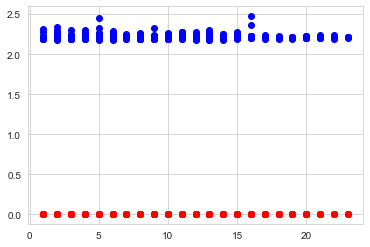

In [8]:
fig, ax = plt.subplots()
ax.plot(sep_data["Prefix Length"], sep_data["SHAP Running Time"], 'ro')#, y = ['SHAP Running Time', 'LIME Running Time'], x = ['Prefix Length'] )#, hue = data['Feature Vector Length'])
ax.plot(sep_data["Prefix Length"], sep_data["LIME Running Time"], 'bo')#, y = ['SHAP Running Time', 'LIME Running Time'], x = ['Prefix Length'] )#, hue = data['Feature Vector Length'])
#grid.map(sns.scatterplot, color=".3")
plt.show()


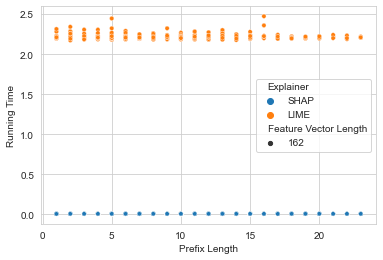

In [9]:
sns.scatterplot(x = all_data['Prefix Length'], y = all_data['Running Time'], hue = all_data['Explainer'], size = all_data['Feature Vector Length'])
plt.show()